In [80]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray
import cartopy.crs as ccrs
from scipy.signal import detrend
import eofs

In [81]:
path = "data/mslp/*.nc"

In [82]:
df = xr.open_mfdataset(path,chunks={'initial_time0_hours':504,'g0_lat_1':29,'g0_lon_2':29})

In [83]:
df = df.rename({'initial_time0_hours':'time','g0_lat_1':'lat','g0_lon_2':'lon','PRMSL_GDS0_MSL':'mslp'})
df.coords['lon'] = (df.coords['lon'] + 180) % 360 - 180
df = df.drop("initial_time0_encoded")
df = df.resample(time='1D').mean().chunk({'time':504,'lat':29,'lon':29})
df

<xarray.Dataset>
Dimensions:  (lat: 29, lon: 29, time: 1461)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1961-12-31
  * lat      (lat) float32 67.5 66.25 65.0 63.75 62.5 ... 36.25 35.0 33.75 32.5
  * lon      (lon) float32 -10.0 -8.75 -7.5 -6.25 -5.0 ... 21.25 22.5 23.75 25.0
Data variables:
    mslp     (time, lat, lon) float32 dask.array<shape=(1461, 29, 29), chunksize=(504, 29, 29)>

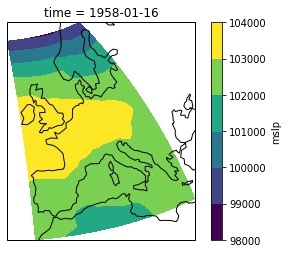

In [84]:
ax = plt.axes(projection=ccrs.Orthographic(-20, 30))
df['mslp'].isel(time=15).plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.coastlines()

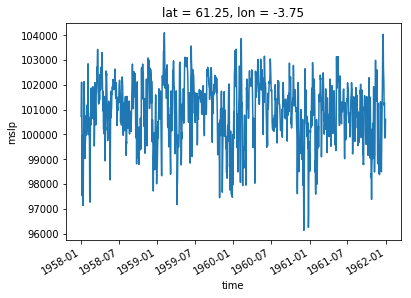

In [85]:
df['mslp'].isel(lat=5, lon=5).plot()

In [86]:
df_roll_mean = df.rolling(time=21,center=True).mean().dropna('time').groupby('time.dayofyear').mean(axis=0)
df_roll_mean

C:\Users\M\Anaconda3\lib\site-packages\xarray\core\groupby.py:758: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 29, lon: 29)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: lat, lon
Data variables:
    mslp       (dayofyear, lat, lon) float32 dask.array<shape=(366, 29, 29), chunksize=(1, 29, 29)>

In [87]:
new_dim = df.rolling(time=21, center=True).construct('dim_roll_days') #Die +- 10 Tage in eine eigene Dim stecken
stacked_dim =new_dim.stack(space1D=('lat','lon')) # Stack into Dimension lat, lon
stacked_dim

<xarray.Dataset>
Dimensions:  (dim_roll_days: 21, space1D: 841, time: 1461)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1961-12-31
  * space1D  (space1D) MultiIndex
  - lat      (space1D) float64 67.5 67.5 67.5 67.5 67.5 ... 67.5 67.5 67.5 66.25
  - lon      (space1D) float64 -10.0 -8.75 -7.5 -6.25 ... 22.5 23.75 25.0 -10.0
Dimensions without coordinates: dim_roll_days
Data variables:
    mslp     (time, dim_roll_days, space1D) float32 dask.array<shape=(1461, 21, 841), chunksize=(504, 21, 841)>

In [88]:
df_std = stacked_dim.groupby('time.dayofyear').std() #Std der 20 Tage pro Tag des Jahres berechnen
df_std

<xarray.Dataset>
Dimensions:    (dayofyear: 366)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    mslp       (dayofyear) float32 dask.array<shape=(366,), chunksize=(1,)>

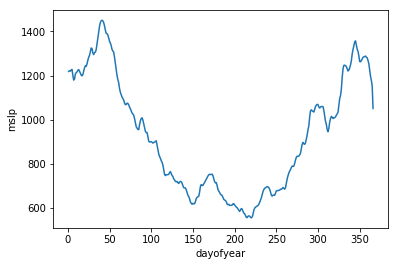

In [89]:
df_std['mslp'].plot()

In [90]:
ano = df - df_roll_mean
ano_norm = ano / df_std

In [91]:
ano

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 29, lon: 29, time: 1461)
Coordinates:
  * lat        (lat) float64 67.5 66.25 65.0 63.75 ... 36.25 35.0 33.75 32.5
  * lon        (lon) float64 -10.0 -8.75 -7.5 -6.25 ... 21.25 22.5 23.75 25.0
  * time       (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1961-12-31
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    mslp       (time, lat, lon, dayofyear) float32 dask.array<shape=(1461, 29, 29, 366), chunksize=(504, 29, 29, 1)>

In [92]:
ano_norm

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 29, lon: 29, time: 1461)
Coordinates:
  * lat        (lat) float64 67.5 66.25 65.0 63.75 ... 36.25 35.0 33.75 32.5
  * lon        (lon) float64 -10.0 -8.75 -7.5 -6.25 ... 21.25 22.5 23.75 25.0
  * time       (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1961-12-31
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    mslp       (time, lat, lon, dayofyear) float32 dask.array<shape=(1461, 29, 29, 366), chunksize=(504, 29, 29, 1)>

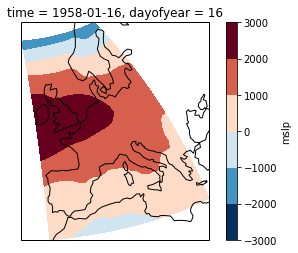

In [93]:
ax = plt.axes(projection=ccrs.Orthographic(-20, 30))
ano['mslp'].isel(time=15, dayofyear=15).plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.coastlines()